In [1]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from scipy.io import loadmat

In [4]:
# import timm

# Data

In [5]:
imdir = '/home/bsorsch/.brainio/image_dicarlo_hvm-public/'
imnames = np.load('data/majaj_2015_imnames_2.npy',allow_pickle=True)

In [6]:
# Image preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
from PIL import Image

def get_batch(i, batch_size):
#     ims = imnames[class_id]
    images = []
    for im in imnames[i*batch_size:(i+1)*batch_size]:
        impath = os.path.join(imdir, im+ '.png')
        images.append(preprocess(Image.open(impath)))
        
    images = torch.stack(images)
        
    return images

# Model

In [8]:
model_name = 'resnet50'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
pretrained = True
model = torch.hub.load(repo, model_name, pretrained=pretrained)

if pretrained:
    emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/{}/'.format(model_name)
else:
    emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/{}_untrained/'.format(model_name)

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [9]:
class AlexnetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(AlexnetBackbone, self).__init__()
        self.N = list(model.children())[-1][-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        x = self.features(x)
        return x


class SqueezeBackbone(torch.nn.Module):
    def __init__(self, model):
        super(SqueezeBackbone, self).__init__()
        self.N = list(model.children())[-1][-3].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.features(x)
        x = self.flatten(x)
        return x


class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

    
class VGGBackbone(torch.nn.Module):
    def __init__(self, model):
        super(VGGBackbone, self).__init__()
        self.N = list(model.children())[-1][3].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        x = self.features(x)
        x = self.flatten(x)
        return x
    
    
class EfficientNetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(EfficientNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        return x

In [10]:
random_projection=True
if 'resnet' in model_name or 'resnext' in model_name:
    backbone = WideResNetBackbone(model, 1)
    random_projection=False
elif 'vgg' in model_name:
    backbone = VGGBackbone(model)
elif 'alexnet' in model_name:
    backbone = AlexnetBackbone(model)
elif 'squeeze' in model_name:
    backbone = SqueezeBackbone(model)
elif 'efficient' in model_name:
    backbone = model
    backbone.N = 1000
    random_projection=False
#     backbone = EfficientNetBackbone(model)
backbone.to('cuda').eval()

WideResNetBackbone(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [11]:
batch_size = 10
input_tensor = get_batch(0,batch_size)
with torch.no_grad():
    output = backbone(input_tensor.cuda()).cpu()

In [12]:
N = 2048
M = output.shape[1]
# idxs = torch.randint(0,100352,(N,))
O = torch.randn((M,2048))/np.sqrt(2048)
O = O.cuda()

In [13]:
# N = 2048
K = 64
P = 50
batch_size = 10
n_classes = len(imnames)

manifolds = []
# for class_id in tqdm(range(n_classes)):
for i in tqdm(range(K*P//batch_size)):
    input_tensor = get_batch(i,batch_size)
    with torch.no_grad():
        output = backbone(input_tensor.cuda())
    manifolds.append((output@O).cpu().numpy())
manifolds = np.stack(manifolds).reshape(K,P,N)

In [14]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/resnet50/'

In [36]:
if not os.path.isdir(emb_path):
    os.mkdir(emb_path)
np.save(os.path.join(emb_path,'manifolds.npy'), manifolds)

In [31]:
# Compute error
m = 1
n_avg = 50

err_all = np.zeros((len(manifolds),len(manifolds)))
for a in tqdm(range(len(manifolds))):
    Xa = manifolds[a]
    for b in range(len(manifolds)):
        Xb = manifolds[b]

        errs = []
        for _ in range(n_avg):
            perma = np.random.permutation(len(Xa))
            permb = np.random.permutation(len(Xb))

            xa,ya = np.split(Xa[perma],(m,))
            xb,yb = np.split(Xb[permb],(m,))
            w = (xa-xb).mean(0)
            mu = (xa+xb).mean(0)/2

            h = ya@w - w@mu
            err = (h<0).mean()
            errs.append(err)
        err_all[a,b] = np.mean(errs)
np.fill_diagonal(err_all,np.nan)

alexnet
0.8405638227513228


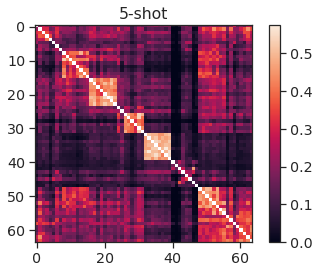

In [20]:
print('alexnet')
with sns.axes_style('ticks'):
    plt.imshow(err_all)
#     plt.xticks(np.arange(len(uniq_labels)),uniq_labels,rotation=90)
#     plt.yticks(np.arange(len(uniq_labels)),uniq_labels)
    plt.colorbar()
    plt.title(str(m)+'-shot')
print(1-np.nanmean(err_all))

0.9625908289241623


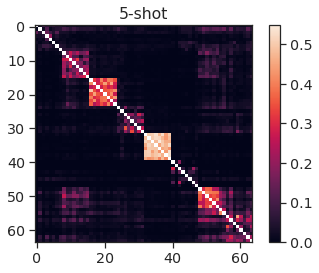

In [53]:
with sns.axes_style('ticks'):
    plt.imshow(err_all)
#     plt.xticks(np.arange(len(uniq_labels)),uniq_labels,rotation=90)
#     plt.yticks(np.arange(len(uniq_labels)),uniq_labels)
    plt.colorbar()
    plt.title(str(m)+'-shot')
print(1-np.nanmean(err_all))

0.9481976943942134


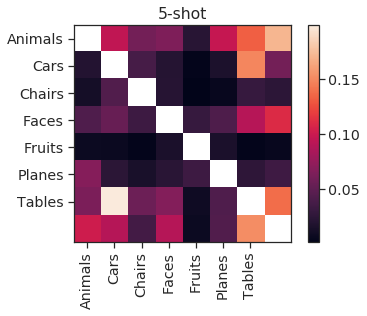

In [87]:
with sns.axes_style('ticks'):
    plt.imshow(err_all)
    plt.xticks(np.arange(len(uniq_labels)),uniq_labels,rotation=90)
    plt.yticks(np.arange(len(uniq_labels)),uniq_labels)
    plt.colorbar()
    plt.title(str(m)+'-shot')
print(1-np.nanmean(err_all))

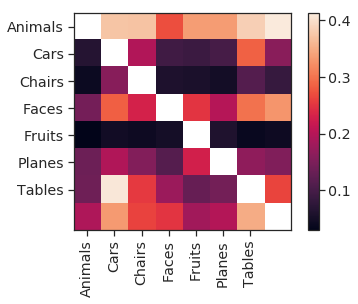

In [84]:
with sns.axes_style('ticks'):
    plt.imshow(err_all)
    plt.xticks(np.arange(len(uniq_labels)),uniq_labels,rotation=90)
    plt.yticks(np.arange(len(uniq_labels)),uniq_labels)
    plt.colorbar()
    plt.title(str(m)+'-shot')
print(1-np.nanmean(err_all))

In [50]:
1-np.nanmean(err_all)

0.8801861471861472

In [31]:
Rs = []
centers = []
Us = []
for manifold in manifolds:
    centers.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs.append(R)
    Us.append(V)
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

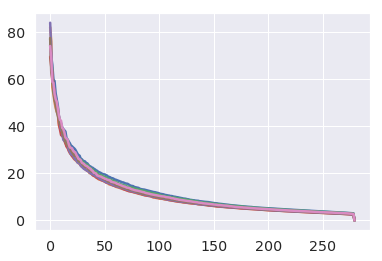

In [32]:
plt.plot(Rs.T);
# plt.xscale('log')
# plt.yscale('log')

In [33]:
Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)
print('Mean: ' + str(np.mean(Ds)))

Mean: 39.046772


In [34]:
Ds

array([43.49218 , 32.774258, 43.381313, 38.24773 , 33.417767, 40.148502,
       41.865635], dtype=float32)

In [36]:
idxs = np.random.choice(2048,168,replace=False)

In [39]:
manifolds_small = manifolds[:,:,idxs]

In [41]:
manifolds_small.shape

(7, 280, 168)

In [42]:
Rs = []
centers = []
Us = []
for manifold in manifolds_small:
    centers.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs.append(R)
    Us.append(V)
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

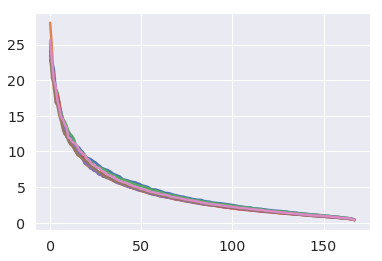

In [43]:
plt.plot(Rs.T);
# plt.xscale('log')
# plt.yscale('log')

In [44]:
Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)
print('Mean: ' + str(np.mean(Ds)))

Mean: 27.808477


In [30]:
os.listdir('data')

['dicarlo_V1_manifolds.npy', 'dicarlo_data', 'majaj_2015_imnames.npy']

In [32]:
np.save('data/dicarlo_resnet_manifolds.npy', manifolds)

In [31]:
manifolds.shape

(8, 400, 2048)

## Geometry

# Layerwise

In [15]:
class Backbone(torch.nn.Module):
    def __init__(self, model, module_idx, layer_idx=None):
        super(Backbone, self).__init__()
        self.layer_idx = layer_idx
        self.pre_features = torch.nn.Sequential(*list(model.children())[:module_idx])
        if layer_idx:
            self.features = torch.nn.Sequential(*list(model.children())[module_idx][:layer_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        if self.layer_idx:
            x = self.features(x)
        x = self.flatten(x)
        return x
# backbone = Backbone(model)
# backbone.to('cuda').eval()

In [16]:
N = 2048
N_all = 169000
idxs = np.random.randint(0,N_all,N)
batch_size = 64
i=0

batch_size = 10
K = 64
P = 50

layers = []
manifolds_all = []
for module_idx in tqdm(range(len(list(model.children())))):
    try:
        len_module = len(list(model.children())[module_idx])
        for layer_idx in range(len_module):
            
            backbone = Backbone(model, module_idx, layer_idx)
            backbone.to('cuda').eval()

            # Get test batch
            input_tensor = get_batch(0,batch_size)
            with torch.no_grad():
                output = backbone(input_tensor.cuda())
            layers.append(list(model.children())[module_idx][layer_idx])
    except:
        layer_idx = 0
        layer = 'layer_' + str(module_idx) + '_' + str(layer_idx)
        
        backbone = Backbone(model, module_idx)
        backbone.to('cuda').eval()

        # Get test batch
        input_tensor = get_batch(0,batch_size)
        with torch.no_grad():
            output = backbone(input_tensor.cuda())
        try:
            layers.append(list(model.children())[module_idx][layer_idx])
        except:
            layers.append('avgpool')

In [17]:
conv_idxs = [0,3,6,8,10,15]

In [18]:
np.array(layers)[conv_idxs]

array(['avgpool', 'avgpool',
       Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
),
       Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), st

In [22]:
N = 2048
N_all = 169000
idxs = np.random.randint(0,N_all,N)
batch_size = 64
i=0

batch_size = 10
K = 64
P = 50

manifolds_all = []
for module_idx in tqdm(range(len(list(model.children())))):
    try:
        len_module = len(list(model.children())[module_idx])
        for layer_idx in range(len_module):
            print('Computing embeddings module '+str(module_idx)+', layer '+str(layer_idx) )
            
            backbone = Backbone(model, module_idx, layer_idx)
            backbone.to('cuda').eval()

            # Get test batch
            input_tensor = get_batch(0,batch_size)
            with torch.no_grad():
                output = backbone(input_tensor.cuda())
            N_all = output.shape[-1]
            O = torch.randn(N_all,N) / np.sqrt(N)
            O = O.cuda()
#             idxs = np.random.randint(0,N_all,N)
            
            manifolds = []
            for i in tqdm(range(K*P//batch_size)):
                input_tensor = get_batch(i,batch_size)
                with torch.no_grad():
                    output = backbone(input_tensor.cuda())
                manifolds.append((output@O).cpu().numpy())
            manifolds = np.stack(manifolds).reshape(K,P,N)
            manifolds_all.append(manifolds)

    except:
        layer_idx = 0
        print('Computing embeddings module '+str(module_idx)+', layer '+str(layer_idx) )
        layer = 'layer_' + str(module_idx) + '_' + str(layer_idx)
        
        backbone = Backbone(model, module_idx)
        backbone.to('cuda').eval()

        # Get test batch
        input_tensor = get_batch(0,batch_size)
        with torch.no_grad():
            output = backbone(input_tensor.cuda())
        N_all = output.shape[-1]
        O = torch.randn(N_all,N) / np.sqrt(N)
        O = O.cuda()
#         idxs = np.random.randint(0,N_all,N)        

        manifolds = []
        for i in tqdm(range(K*P//batch_size)):
            input_tensor = get_batch(i,batch_size)
            with torch.no_grad():
                output = backbone(input_tensor.cuda())
            manifolds.append((output@O).cpu().numpy())
        manifolds = np.stack(manifolds).reshape(K,P,N)
        manifolds_all.append(manifolds)

Computing embeddings module 0, layer 0



Computing embeddings module 1, layer 0



Computing embeddings module 2, layer 0



Computing embeddings module 3, layer 0



Computing embeddings module 4, layer 0



Computing embeddings module 4, layer 1



Computing embeddings module 4, layer 2



Computing embeddings module 5, layer 0



Computing embeddings module 5, layer 1



Computing embeddings module 5, layer 2



Computing embeddings module 5, layer 3



Computing embeddings module 6, layer 0



Computing embeddings module 6, layer 1



Computing embeddings module 6, layer 2



Computing embeddings module 6, layer 3



Computing embeddings module 6, layer 4



Computing embeddings module 6, layer 5



Computing embeddings module 7, layer 0



Computing embeddings module 7, layer 1



Computing embeddings module 7, layer 2



Computing embeddings module 8, layer 0



Computing embeddings module 9, layer 0


In [24]:
if not os.path.isdir(emb_path):
    os.mkdir(emb_path)
np.save(os.path.join(emb_path, 'manifolds_layerwise.npy'), manifolds_all)

In [121]:
manifolds_all_load = np.load(os.path.join(emb_path, 'manifolds_layerwise.npy'))

In [122]:
N = 2048
M = 88
A = np.random.randn(N,M)/np.sqrt(M)

manifolds_all = []
for manifolds in manifolds_all_load:
    manifolds_all.append(manifolds@A)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2048 is different from 88)

In [24]:
from jax import numpy as np
from jax import jit
from numpy import random

In [25]:
import numpy as np

In [ ]:
m = 5
n_test = 10000

err_means_all = []
err_stds_all = []
for manifolds in tqdm(manifolds_all):
    manifolds = np.stack(manifolds)
    # re-define
#     @jit
    def compute_2way_err():
        err_means = []
        err_stds = []
        for i in tqdm(range(K), leave=False):
            err_mean = []
            err_std = []
            for j in tqdm(range(K), leave=False):
                if i != j:
                    X1 = manifolds[i]
                    X2 = manifolds[j]

                    idxs1 = random.randint(0, len(X1), [m, n_test])
                    idxs2 = random.randint(0, len(X2), [m, n_test])
                    mu1 = X1[idxs1].mean(0)
                    mu2 = X2[idxs2].mean(0)
                    w = mu1 - mu2
                    mu = 0.5*(mu1 + mu2)
                    pred = w.dot(X1.T) - (w*mu).sum(-1, keepdims=True)

                    err = (pred < 0).mean(-1)
                    err_mean.append(err.mean())
                    err_std.append(err.std())
            err_mean = np.stack(err_mean)
            err_std = np.stack(err_std)
            err_means.append(err_mean)
            err_stds.append(err_std)

        err_means = np.stack(err_means)
        err_stds = np.stack(err_stds)
        return err_means, err_stds

    err_mean, err_std = compute_2way_err()
    err_means_all.append(err_mean)
    err_stds_all.append(err_std)
err_means_all = np.stack(err_means_all)
err_stds_all = np.stack(err_stds_all)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



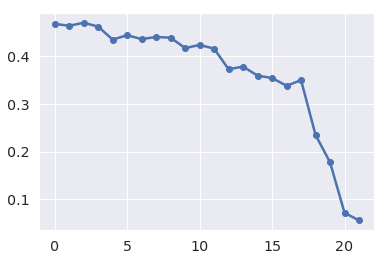

In [36]:
plt.plot(err_means_all.mean((1,2)), 'o-')

In [114]:
import numpy as np

In [115]:
def geometry(centers,Rs,Us,m):
    K = len(centers)
    P = Rs.shape[1]
    dists = np.sqrt(((centers[:,None] - centers[None])**2).sum(-1))
    dist_norm = dists / np.sqrt((Rs**2).sum(-1)[:,None] / P)

    Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)

    # Center-subspace
    csa = []
    csb = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())
            else:
                csa.append(np.nan)
                csb.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)

    # Subspace-subspace
    ss = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                ss.append(np.nan)
    ss = np.stack(ss).reshape(K,K)

    css = (csa + csb/m) * dist_norm**2

    bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
    SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds[:,None]/m + css + ss/m)
    
    return dist_norm, Ds, csa, ss, SNR

In [116]:
from scipy.spatial.distance import pdist, squareform
m = 5

K = len(manifolds)
PRs_all = []
Rs_all = []
dists_all = []
css_all = []
SNRs_all = []
for manifolds in tqdm(manifolds_all):
    manifolds = np.stack(manifolds)
    
    Rs = []
    centers = []
    Us = []
    for manifold in manifolds:
        centers.append(manifold.mean(0))
        U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
        Rs.append(R)
        Us.append(V)
    Rs = np.stack(Rs)
    Rs_all.append(Rs)
    centers = np.stack(centers)
    Us = np.stack(Us)
    
    dist_norm, Ds, csa, ss, SNR = geometry(centers,Rs,Us,m)
    dists_all.append(dist_norm)
    PRs_all.append(Ds)
    css_all.append(csa)
    SNRs_all.append(SNR)
    
Rs_all = np.stack(Rs_all)
dists_all = np.stack(dists_all)
PRs_all = np.stack(PRs_all)
css_all = np.stack(css_all)
SNRs_all = np.stack(SNRs_all)

Text(0.5, 0.98, 'ResNet50 (V4 layer)')

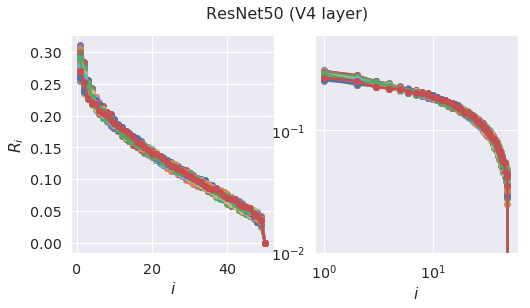

In [127]:
idx = 12
R = Rs_all[idx] / np.sqrt((Rs_all[idx]**2).sum(-1, keepdims=True))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(np.arange(1,51),R.T, 'o-');
plt.xlabel(r'$i$')
plt.ylabel(r'$R_i$')

plt.subplot(122)
plt.plot(np.arange(1,51),R.T, 'o-');
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,0.6])
plt.xlabel(r'$i$');
plt.suptitle('ResNet50 (V4 layer)', fontsize=16)

Text(0.5, 0.98, 'ResNet50 (IT layer)')

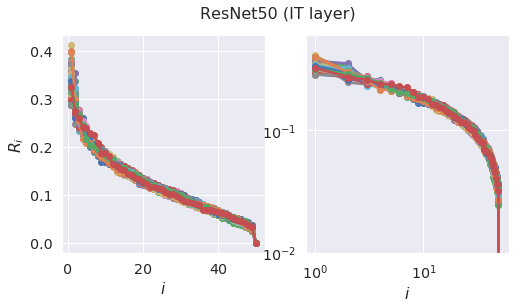

In [130]:
idx = 20
R = Rs_all[idx] / np.sqrt((Rs_all[idx]**2).sum(-1, keepdims=True))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(np.arange(1,51),R.T, 'o-');
plt.xlabel(r'$i$')
plt.ylabel(r'$R_i$')

plt.subplot(122)
plt.plot(np.arange(1,51),R.T, 'o-');
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,0.6])
plt.xlabel(r'$i$');
plt.suptitle('ResNet50 (IT layer)', fontsize=16)

In [86]:
((R**2).sum(-1)**2 / (R**4).sum(-1)).mean()

22.684507117542612

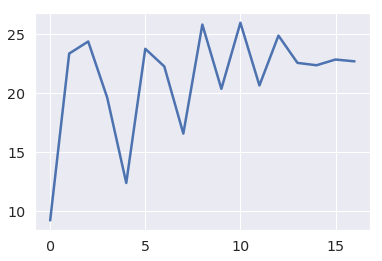

In [91]:
plt.plot(((Rs_all**2).sum(-1)**2 / (Rs_all**4).sum(-1)).mean(1))

In [94]:
Ds = np.load(os.path.join(emb_path,'Ds_layerwise.npy'))

In [36]:
np.save(os.path.join(emb_path,'SNRs_layerwise.npy'),SNRs_all)
np.save(os.path.join(emb_path,'Ds_layerwise.npy'),PRs_all)
np.save(os.path.join(emb_path,'dist_norm_layerwise.npy'),dists_all)
np.save(os.path.join(emb_path,'css_layerwise.npy'),css_all)

In [69]:
import numpy as onp

In [70]:
err_v1 = 0.475
err_v4 = 0.353
err_IT = 0.192

SNR_v1 = 0.096
SNR_v4 = 0.342
SNR_IT = 0.89

dist_v1 = 0.11
dist_v4 = 0.44
dist_IT = 0.65

D_v1 = 76.9
D_v4 = 6.25
D_IT = 15.4

css_v1 = 0.011
css_v4 = 0.123
css_IT = 0.062

No handles with labels found to put in legend.


NameError: name 'err_means_all' is not defined

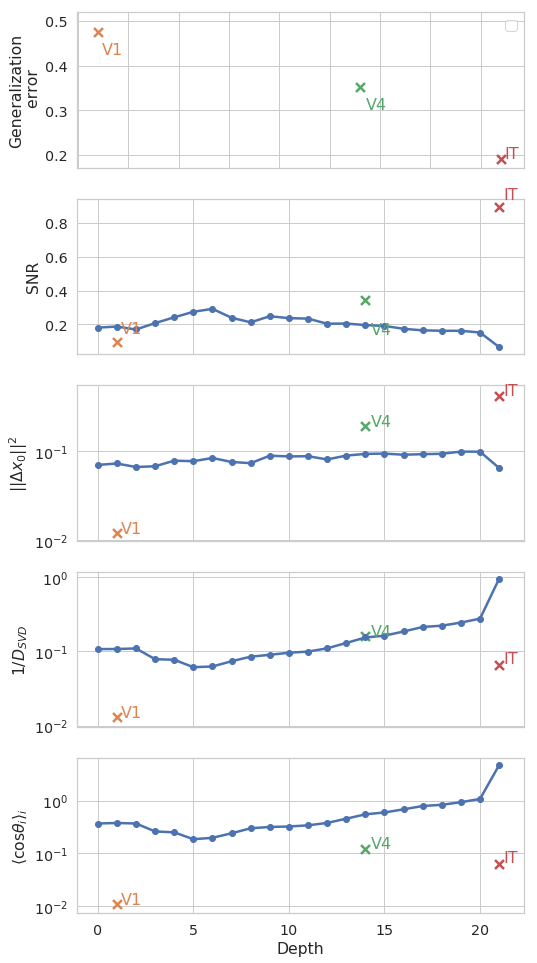

In [96]:
m = 5
cm = plt.cm.get_cmap('tab20c').colors
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,20))
fmt = 'o-'

v1_idx = 1
v4_idx = 14
IT_idx = 21

# Error
ax = plt.subplot(611)
# ResNet50
# plt.plot(err_means_all.mean((1,2)), fmt, c='C0', label='ResNet50')
plt.ylabel('Generalization\n error')
ax.xaxis.set_ticklabels([])
plt.scatter(v1_idx,err_v1,marker='x',s=80, color='C1')
ax.annotate('V1',(v1_idx+0.2,err_v1-0.05), color='C1',fontsize=16)
plt.scatter(v4_idx,err_v4,marker='x',s=80, color='C2')
ax.annotate('V4',(v4_idx+0.3,err_v4-0.05), color='C2',fontsize=16)
plt.scatter(IT_idx,err_IT,marker='x',s=80, color='C3')
ax.annotate('IT',(IT_idx+0.2,err_IT), color='C3',fontsize=16)
plt.legend(loc=1)

# SNR
ax5 = plt.subplot(612)
plt.plot(onp.nanmean(SNRs_all,(1,2)), 'o-', c='C0', label='ResNet50')
plt.ylabel('SNR')
ax5.xaxis.set_ticklabels([])
plt.scatter(v1_idx,SNR_v1,marker='x',s=80, color='C1')
ax5.annotate('V1',(v1_idx+0.2,SNR_v1+0.05), color='C1',fontsize=16)
plt.scatter(v4_idx,SNR_v4,marker='x',s=80, color='C2')
ax5.annotate('V4',(v4_idx+0.3,SNR_v4-0.2), color='C2',fontsize=16)
plt.scatter(IT_idx,SNR_IT,marker='x',s=80, color='C3')
ax5.annotate('IT',(IT_idx+0.2,SNR_IT+0.05), color='C3',fontsize=16)
# plt.legend()

# Dimension
ax2 = plt.subplot(614)
plt.plot(1/PRs_all.mean(-1), 'o-', c='C0', label='')
plt.ylabel(r'$1/D_{SVD}$')
plt.yscale('log')
ax2.xaxis.set_ticklabels([])
plt.scatter(v1_idx,1/D_v1,marker='x',s=80, color='C1')
ax2.annotate('V1',(v1_idx+0.2,1/D_v1), color='C1',fontsize=16)
plt.scatter(v4_idx,1/D_v4,marker='x',s=80, color='C2')
ax2.annotate('V4',(v4_idx+0.3,1/D_v4), color='C2',fontsize=16)
plt.scatter(IT_idx,1/D_IT,marker='x',s=80, color='C3')
ax2.annotate('IT',(IT_idx+0.2,1/D_IT+0.005), color='C3',fontsize=16)
# plt.legend()

# Dists
ax3 = plt.subplot(613)
# ResNet50
plt.plot(dists_all.mean((1,2))**2, 'o-', c='C0', label='ResNet50')
plt.ylabel(r'$||\Delta x_0||^2$')
plt.yscale('log')
ax3.xaxis.set_ticklabels([])
plt.scatter(v1_idx,dist_v1**2,marker='x',s=80, color='C1')
ax3.annotate('V1',(v1_idx+0.2,dist_v1**2), color='C1',fontsize=16)
plt.scatter(v4_idx,dist_v4**2,marker='x',s=80, color='C2')
ax3.annotate('V4',(v4_idx+0.3,dist_v4**2), color='C2',fontsize=16)
plt.scatter(IT_idx,dist_IT**2,marker='x',s=80, color='C3')
ax3.annotate('IT',(IT_idx+0.2,dist_IT**2+0.005), color='C3',fontsize=16)
# plt.legend()

# noise
ax4 = plt.subplot(615)
plt.plot((m+1)*onp.nanmean(css_all,(1,2)) , fmt, c='C0', label=r'$\langle \cos\theta_i\rangle_i$')
plt.ylabel(r'$\langle \cos\theta_i\rangle_i$')
# plt.legend()
plt.yscale('log')
plt.xlabel('Depth');
plt.scatter(v1_idx,css_v1,marker='x',s=80, color='C1')
ax4.annotate('V1',(v1_idx+0.2,css_v1), color='C1',fontsize=16)
plt.scatter(v4_idx,css_v4,marker='x',s=80, color='C2')
ax4.annotate('V4',(v4_idx+0.3,css_v4), color='C2',fontsize=16)
plt.scatter(IT_idx,css_IT,marker='x',s=80, color='C3')
ax4.annotate('IT',(IT_idx+0.2,css_IT+0.005), color='C3',fontsize=16)


# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, len(err_means_all), 5)
minor_ticks = np.arange(0, len(err_means_all))

# And a corresponding grid
ax.grid(which='minor')
ax2.grid(which='minor', linestyle=':', alpha=0.5)
ax3.grid(which='minor', linestyle=':', alpha=0.5)
ax4.grid(which='minor', linestyle=':', alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0.1)

# plt.savefig('images/macaque_layerwise.pdf')

No handles with labels found to put in legend.


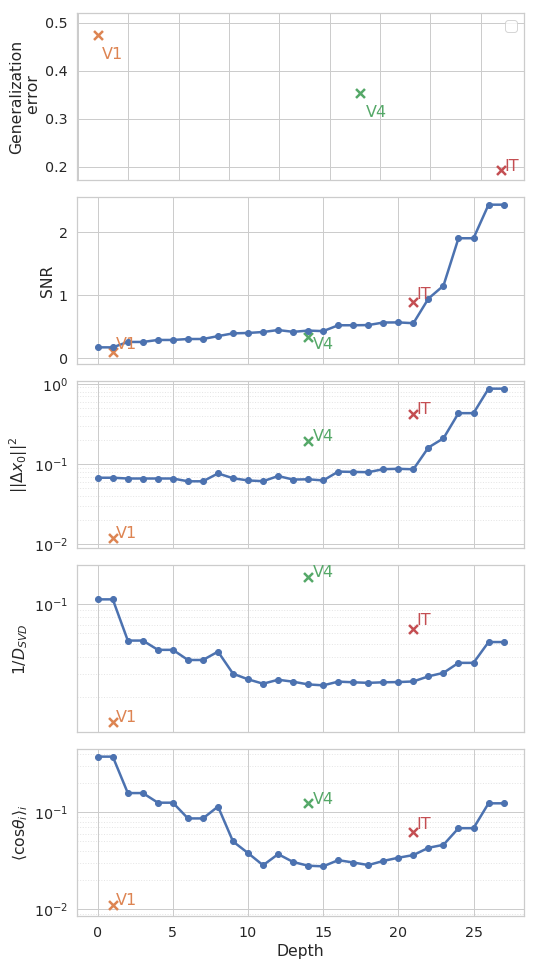

In [37]:
m = 5
cm = plt.cm.get_cmap('tab20c').colors
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,20))
fmt = 'o-'

v1_idx = 1
v4_idx = 14
IT_idx = 21

# Error
ax = plt.subplot(611)
# ResNet50
# plt.plot(err_means_all.mean((1,2)), fmt, c='C0', label='ResNet50')
plt.ylabel('Generalization\n error')
ax.xaxis.set_ticklabels([])
plt.scatter(v1_idx,err_v1,marker='x',s=80, color='C1')
ax.annotate('V1',(v1_idx+0.2,err_v1-0.05), color='C1',fontsize=16)
plt.scatter(v4_idx,err_v4,marker='x',s=80, color='C2')
ax.annotate('V4',(v4_idx+0.3,err_v4-0.05), color='C2',fontsize=16)
plt.scatter(IT_idx,err_IT,marker='x',s=80, color='C3')
ax.annotate('IT',(IT_idx+0.2,err_IT), color='C3',fontsize=16)
plt.legend(loc=1)

# SNR
ax5 = plt.subplot(612)
plt.plot(onp.nanmean(SNRs_all,(1,2)), 'o-', c='C0', label='ResNet50')
plt.ylabel('SNR')
ax5.xaxis.set_ticklabels([])
plt.scatter(v1_idx,SNR_v1,marker='x',s=80, color='C1')
ax5.annotate('V1',(v1_idx+0.2,SNR_v1+0.05), color='C1',fontsize=16)
plt.scatter(v4_idx,SNR_v4,marker='x',s=80, color='C2')
ax5.annotate('V4',(v4_idx+0.3,SNR_v4-0.2), color='C2',fontsize=16)
plt.scatter(IT_idx,SNR_IT,marker='x',s=80, color='C3')
ax5.annotate('IT',(IT_idx+0.2,SNR_IT+0.05), color='C3',fontsize=16)
# plt.legend()

# Dimension
ax2 = plt.subplot(614)
plt.plot(1/PRs_all.mean(-1), 'o-', c='C0', label='')
plt.ylabel(r'$1/D_{SVD}$')
plt.yscale('log')
ax2.xaxis.set_ticklabels([])
plt.scatter(v1_idx,1/D_v1,marker='x',s=80, color='C1')
ax2.annotate('V1',(v1_idx+0.2,1/D_v1), color='C1',fontsize=16)
plt.scatter(v4_idx,1/D_v4,marker='x',s=80, color='C2')
ax2.annotate('V4',(v4_idx+0.3,1/D_v4), color='C2',fontsize=16)
plt.scatter(IT_idx,1/D_IT,marker='x',s=80, color='C3')
ax2.annotate('IT',(IT_idx+0.2,1/D_IT+0.005), color='C3',fontsize=16)
# plt.legend()

# Dists
ax3 = plt.subplot(613)
# ResNet50
plt.plot(dists_all.mean((1,2))**2, 'o-', c='C0', label='ResNet50')
plt.ylabel(r'$||\Delta x_0||^2$')
plt.yscale('log')
ax3.xaxis.set_ticklabels([])
plt.scatter(v1_idx,dist_v1**2,marker='x',s=80, color='C1')
ax3.annotate('V1',(v1_idx+0.2,dist_v1**2), color='C1',fontsize=16)
plt.scatter(v4_idx,dist_v4**2,marker='x',s=80, color='C2')
ax3.annotate('V4',(v4_idx+0.3,dist_v4**2), color='C2',fontsize=16)
plt.scatter(IT_idx,dist_IT**2,marker='x',s=80, color='C3')
ax3.annotate('IT',(IT_idx+0.2,dist_IT**2+0.005), color='C3',fontsize=16)
# plt.legend()

# noise
ax4 = plt.subplot(615)
plt.plot((m+1)*onp.nanmean(css_all,(1,2)) , fmt, c='C0', label=r'$\langle \cos\theta_i\rangle_i$')
plt.ylabel(r'$\langle \cos\theta_i\rangle_i$')
# plt.legend()
plt.yscale('log')
plt.xlabel('Depth');
plt.scatter(v1_idx,css_v1,marker='x',s=80, color='C1')
ax4.annotate('V1',(v1_idx+0.2,css_v1), color='C1',fontsize=16)
plt.scatter(v4_idx,css_v4,marker='x',s=80, color='C2')
ax4.annotate('V4',(v4_idx+0.3,css_v4), color='C2',fontsize=16)
plt.scatter(IT_idx,css_IT,marker='x',s=80, color='C3')
ax4.annotate('IT',(IT_idx+0.2,css_IT+0.005), color='C3',fontsize=16)


# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, len(err_means_all), 5)
minor_ticks = np.arange(0, len(err_means_all))

# And a corresponding grid
ax.grid(which='minor')
ax2.grid(which='minor', linestyle=':', alpha=0.5)
ax3.grid(which='minor', linestyle=':', alpha=0.5)
ax4.grid(which='minor', linestyle=':', alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0.1)

# plt.savefig('images/macaque_layerwise.pdf')

## brain score

In [43]:
macaque_dir = '/mnt/fs2/bsorsch/manifold/embeddings_new/macaque'
manifolds_IT = np.load(os.path.join(macaque_dir,'manifolds_IT.npy'))
manifolds_v4 = np.load(os.path.join(macaque_dir,'manifolds_v4.npy'))

In [201]:
np.save(os.path.join(macaque_dir, 'manifolds_resnet_layerwise.npy'), manifolds_all)

In [202]:
from sklearn.linear_model import LinearRegression

In [250]:
perm = np.random.permutation(3200)
A = np.random.randn(2048,168) / np.sqrt(168)
Xtrain,Xtest = np.split(np.vstack(manifolds_all[-1])[perm],2)
Ytrain,Ytest = np.split(np.vstack(manifolds_IT)[perm],2)

In [253]:
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

In [226]:
pls = PLSRegression(n_components=25,scale=False)

In [ ]:
pls.fit(Xtrain,Ytrain)
Yhat = pls.predict(Xtest)
r,_ = pearsonr(Ytest.ravel(),Yhat.ravel())
print(r)

In [336]:
A = np.random.randn(2048,168) / np.sqrt(2048)
rs = []
non_isom = []
for manifolds in tqdm(manifolds_all):
    perm = np.random.permutation(3200)
    Xtrain,Xtest = np.split(np.vstack(manifolds@A)[perm],2)
    Ytrain,Ytest = np.split(np.vstack(manifolds_IT)[perm],2)
    linreg.fit(Xtrain,Ytrain)
    Yhat = linreg.predict(Xtest)
    r = np.corrcoef(Ytest.ravel(), Yhat.ravel())[0,1]
    rs.append(r)
    
    O = linreg.coef_
    eigs, eigvs = np.linalg.eig(O)
    eigs /= np.abs(eigs).mean()
    non_isom.append(np.mean((np.abs(eigs)-1)**2))

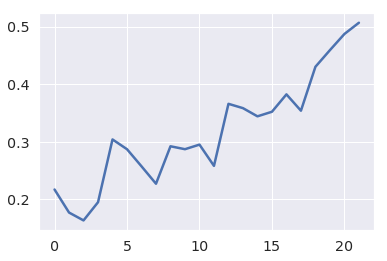

In [337]:
plt.plot(rs)

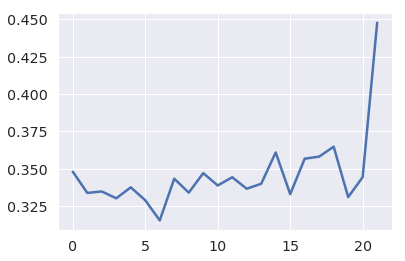

In [338]:
plt.plot(non_isom)

In [339]:
A = np.random.randn(2048,88) / np.sqrt(88)
rs = []
non_isom = []
for manifolds in tqdm(manifolds_all):
    perm = np.random.permutation(3200)
    Xtrain,Xtest = np.split(np.vstack(manifolds@A)[perm],2)
    Ytrain,Ytest = np.split(np.vstack(manifolds_v4)[perm],2)
    linreg.fit(Xtrain,Ytrain)
    Yhat = linreg.predict(Xtest)
    r = np.corrcoef(Ytest.ravel(), Yhat.ravel())[0,1]
    rs.append(r)
    
    O = linreg.coef_
    eigs, eigvs = np.linalg.eig(O)
    eigs /= np.abs(eigs).mean()
    non_isom.append(np.mean((np.abs(eigs)-1)**2))

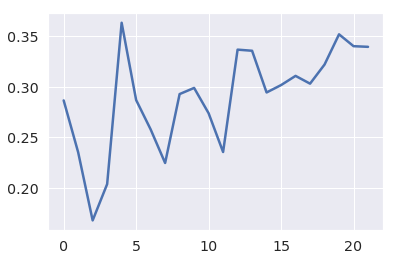

In [340]:
plt.plot(rs)

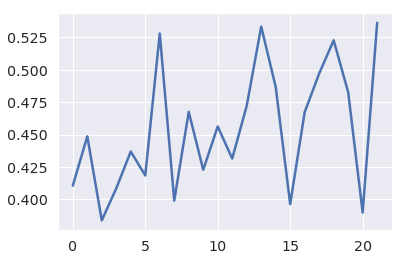

In [341]:
plt.plot(non_isom)

In [334]:
np.mean((np.abs(eigs) - 1)**2)

0.44219416350028157

In [ ]:
A = np.random.randn(2048,168) / np.sqrt(168)
rs = []
for manifolds in tqdm(manifolds_all):
    perm = np.random.permutation(3200)
    Xtrain,Xtest = np.split(np.vstack(manifolds)[perm],2)
    Ytrain,Ytest = np.split(np.vstack(manifolds_IT)[perm],2)
    pls.fit(Xtrain,Ytrain)
    Yhat = pls.predict(Xtest)
    r = np.corrcoef(Ytest.ravel(), Yhat.ravel())[0,1]
    rs.append(r)

In [319]:
A = np.random.randn(2048,168) / np.sqrt(2048)

perm = np.random.permutation(3200)
Xtrain,Xtest = np.split(np.vstack(manifolds@A)[perm],2)
Ytrain,Ytest = np.split(np.vstack(manifolds_IT)[perm],2)
pls.fit(Xtrain,Ytrain)


PLSRegression(copy=True, max_iter=500, n_components=25, scale=False, tol=1e-06)

(-0.5063487663361826,
 0.25587681413134067,
 -0.2479871222069856,
 0.24798712220698557)

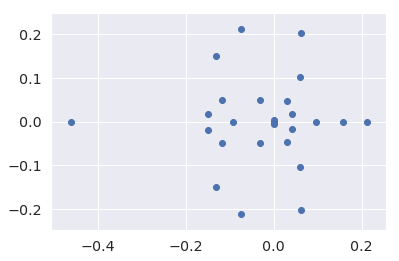

In [320]:
O = pls.coef_
eigs, eigvs = np.linalg.eig(O)
plt.scatter(np.real(eigs), np.imag(eigs))
plt.axis('equal')

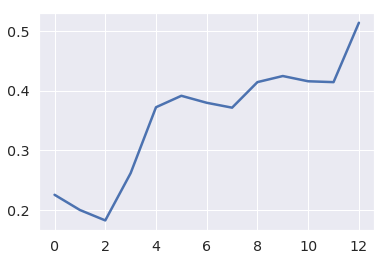

In [261]:
plt.plot(rs)

In [345]:
# procrustes
from scipy.linalg import orthogonal_procrustes


n_avg = 10
rs = []
for manifolds in tqdm(manifolds_all):
    for _ in range(n_avg):
        A = np.random.randn(2048,168) / np.sqrt(168)
        perm = np.random.permutation(3200)
        Xtrain,Xtest = np.split(np.vstack(manifolds@A)[perm],2)
        Ytrain,Ytest = np.split(np.vstack(manifolds_IT)[perm],2)

        R,_ = orthogonal_procrustes(Xtrain - Xtrain.mean(0), Ytrain - Ytrain.mean(0))

        Yhat = (Xtest - Xtrain.mean(0))@R + Ytrain.mean(0)

        r = np.corrcoef(Ytest.ravel(),Yhat.ravel())[0,1]
        rs.append(r)
rs = np.stack(rs).reshape(len(manifolds_all), n_avg).mean(-1)

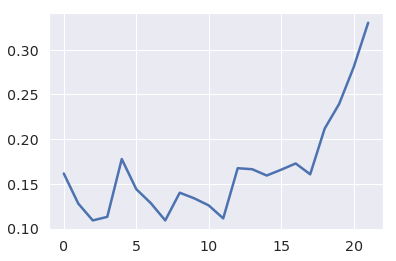

In [349]:
plt.plot(rs)

In [300]:
np.corrcoef(Ytest.ravel(),Yhat.ravel())

array([[1.        , 0.19103839],
       [0.19103839, 1.        ]])

In [117]:
eigs, eigvs = np.linalg.eig(R)
plt.scatter(np.real(eigs), np.imag(eigs))
plt.axis('equal')

# Compressed sensing

In [176]:
manifolds.shape

(8, 400, 2048)

In [192]:
manifolds.shape

(8, 400, 2048)

In [212]:
Ms = np.logspace(5,11,10,base=2)

In [214]:
M = 10
Ms = np.logspace(5,11,10,base=2)
err_means_all = []
err_stds_all = []
n_avg = 2
for M in tqdm(Ms):
    for _ in range(n_avg):
        idxs = random.choice(N,int(M),replace=False)
        msmall = manifolds[:,:,idxs] + random.randn(8,400,int(M)) / 1.6

        # re-define
        @jit
        def compute_2way_err():
            err_means = []
            err_stds = []
            for i in range(n_classes):
                err_mean = []
                err_std = []
                for j in range(n_classes):
                    if i != j:
                        X1 = msmall[i]
                        X2 = msmall[j]

                        idxs1 = random.randint(0, len(X1), [m, n_test])
                        idxs2 = random.randint(0, len(X2), [m, n_test])
                        mu1 = X1[idxs1].mean(0)
                        mu2 = X2[idxs2].mean(0)
                        w = mu1 - mu2
                        mu = 0.5*(mu1 + mu2)
                        pred = w.dot(X1.T) - (w*mu).sum(-1, keepdims=True)

                        err = (pred < 0).mean(-1)
                        err_mean.append(err.mean())
                        err_std.append(err.std())
                err_mean = np.stack(err_mean)
                err_std = np.stack(err_std)
                err_means.append(err_mean)
                err_stds.append(err_std)

            err_means = np.stack(err_means)
            err_stds = np.stack(err_stds)
            return err_means, err_stds

        err_mean, err_std = compute_2way_err()
        err_means_all.append(err_mean)
        err_stds_all.append(err_std)
err_means_all = np.stack(err_means_all)
err_stds_all = np.stack(err_stds_all)

In [215]:
err_means_all = np.stack(err_means_all).reshape(len(Ms),-1)

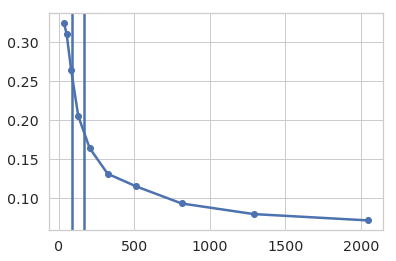

In [216]:
plt.plot(Ms,err_means_all.mean(1), 'o-')
plt.axvline(88)
plt.axvline(168)

In [235]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

In [227]:
sigmas = np.logspace(-3,1,10)
Dsvds = []
for sigma in tqdm(sigmas):
    msmall = manifolds + random.randn(8,400,int(M)) * sigma 
    for manifold in msmall:
        center = manifold.mean(0)
        _,R,_ = np.linalg.svd(manifold - center)
        Dsvd = np.sum(R**2)**2 / np.sum(R**4)
        Dsvds.append(Dsvd)

In [228]:
Dsvds = np.stack(Dsvds).reshape(len(sigmas), len(manifolds))

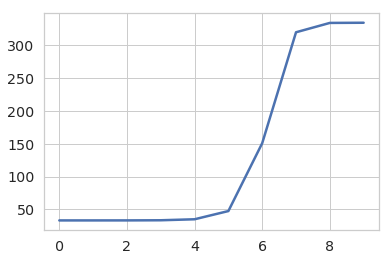

In [229]:
plt.plot(np.mean(Dsvds,axis=-1))

In [19]:
sigmas = np.logspace(-3,1,10)
Dsvds = []
N = 2048
Ms = np.logspace(5,11,10,base=2)
n_avg = 1
for M in tqdm(Ms):
    for _ in range(n_avg):
        idxs = np.random.choice(N,int(M),replace=False)
        msmall = manifolds[:,:,idxs]
        for manifold in msmall:
            center = manifold.mean(0)
            _,R,_ = np.linalg.svd(manifold - center)
            Dsvd = np.sum(R**2)**2 / np.sum(R**4)
            Dsvds.append(Dsvd)

In [24]:
Dsvds = np.stack(Dsvds).reshape(len(Ms),n_avg,8)

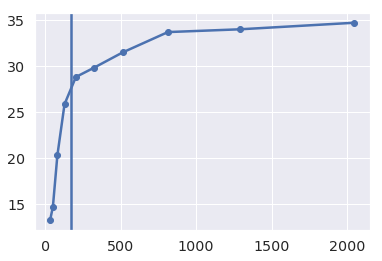

In [28]:
plt.plot(Ms,Dsvds.mean((1,2)), 'o-')
plt.axvline(168)

# classification

In [51]:
from sklearn.svm import LinearSVC

In [52]:
svm = LinearSVC()

In [53]:
Xtrain = []
Xtest = []
for manifold in manifolds:
    test_idxs, train_idxs = np.split(np.random.permutation(280),(56,))
    Xtrain.append(manifold[train_idxs])
    Xtest.append(manifold[test_idxs])
Xtrain = np.vstack(Xtrain)
Xtest = np.vstack(Xtest)

In [54]:
ytrain = np.repeat(np.arange(7),224)
ytest = np.repeat(np.arange(7),56)

In [55]:
svm.fit(Xtrain, ytrain)

/home/bsorsch/.tf2/lib/python3.5/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [56]:
yhat = svm.predict(Xtest)

In [57]:
np.mean(yhat==ytest)

0.8826530612244898

# Gabors

In [8]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

In [9]:
def gabor_kernel(frequency,  sigma_x, sigma_y, theta=0, offset=0, ks=61):

    w = ks // 2
    grid_val = torch.arange(-w, w+1, dtype=torch.float)
    x, y = torch.meshgrid(grid_val, grid_val)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    g = torch.zeros(y.shape)
    g[:] = torch.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y
    g *= torch.cos(2 * np.pi * frequency * rotx + offset)

    return g


def sample_dist(hist, bins, ns, scale='linear'):
    rand_sample = np.random.rand(ns)
    if scale == 'linear':
        rand_sample = np.interp(rand_sample, np.hstack(([0], hist.cumsum())), bins)
    elif scale == 'log2':
        rand_sample = np.interp(rand_sample, np.hstack(([0], hist.cumsum())), np.log2(bins))
        rand_sample = 2**rand_sample
    elif scale == 'log10':
        rand_sample = np.interp(rand_sample, np.hstack(([0], hist.cumsum())), np.log10(bins))
        rand_sample = 10**rand_sample
    return rand_sample

In [10]:
class Identity(nn.Module):
    def forward(self, x):
        return x


class GFB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=4):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
        self.padding = (kernel_size // 2, kernel_size // 2)

        # Param instatiations
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size))

    def forward(self, x):
        return F.conv2d(x, self.weight, None, self.stride, self.padding)

    def initialize(self, sf, theta, sigx, sigy, phase):
        random_channel = torch.randint(0, self.in_channels, (self.out_channels,))
        for i in range(self.out_channels):
            self.weight[i, random_channel[i]] = gabor_kernel(frequency=sf[i], sigma_x=sigx[i], sigma_y=sigy[i],
                                                             theta=theta[i], offset=phase[i], ks=self.kernel_size[0])
        self.weight = nn.Parameter(self.weight, requires_grad=False)


class VOneBlock(nn.Module):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3

        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 2)

        self.simple = nn.ReLU(inplace=True)
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = nn.ReLU(inplace=True)
        self.output = Identity()

    def forward(self, x):
        # Gabor activations [Batch, out_channels, H/stride, W/stride]
        x = self.gabors_f(x)
        # Noise [Batch, out_channels, H/stride, W/stride]
        x = self.noise_f(x)
        # V1 Block output: (Batch, out_channels, H/stride, W/stride)
        x = self.output(x)
        return x

    def gabors_f(self, x):
        s_q0 = self.simple_conv_q0(x)
        s_q1 = self.simple_conv_q1(x)
        c = self.complex(torch.sqrt(s_q0[:, self.simple_channels:, :, :] ** 2 +
                                    s_q1[:, self.simple_channels:, :, :] ** 2) / np.sqrt(2))
        s = self.simple(s_q0[:, 0:self.simple_channels, :, :])
        return self.gabors(self.k_exc * torch.cat((s, c), 1))

    def noise_f(self, x):
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * torch.sqrt(F.relu(x.clone()) + eps)
            else:
                x += torch.distributions.normal.Normal(torch.zeros_like(x), scale=1).rsample() * \
                     torch.sqrt(F.relu(x.clone()) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        noise_mean = torch.zeros(batch_size, self.out_channels, int(self.input_size/self.stride), int(self.input_size/self.stride))
        if seed:
            torch.manual_seed(seed)
        if self.noise_mode == 'neuronal':
            self.fixed_noise = torch.distributions.normal.Normal(noise_mean, scale=1).rsample().to(device)

    def unfix_noise(self):
        self.fixed_noise = None

In [11]:
def generate_gabor_param(features, seed=0, rand_flag=False, sf_corr=0, sf_max=9, sf_min=0):
    # Generates random sample
    np.random.seed(seed)

    phase_bins = np.array([0, 360])
    phase_dist = np.array([1])

    if rand_flag:
        print('Uniform gabor parameters')
        ori_bins = np.array([0, 180])
        ori_dist = np.array([1])

        nx_bins = np.array([0.1, 10**0.2])
        nx_dist = np.array([1])

        ny_bins = np.array([0.1, 10**0.2])
        ny_dist = np.array([1])

        # sf_bins = np.array([0.5, 8])
        # sf_dist = np.array([1])

        sf_bins = np.array([0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0, 5.6, 8])
        sf_dist = np.array([1,  1,  1, 1, 1, 1, 1, 1])

        sfmax_ind = np.where(sf_bins < sf_max)[0][-1]
        sfmin_ind = np.where(sf_bins >= sf_min)[0][0]

        sf_bins = sf_bins[sfmin_ind:sfmax_ind+1]
        sf_dist = sf_dist[sfmin_ind:sfmax_ind]

        sf_dist = sf_dist / sf_dist.sum()
    else:
        print('Neuronal distributions gabor parameters')
        # DeValois 1982a
        ori_bins = np.array([-22.5, 22.5, 67.5, 112.5, 157.5])
        ori_dist = np.array([66, 49, 77, 54])
        ori_dist = ori_dist / ori_dist.sum()

        # Schiller 1976
        cov_mat = np.array([[1, sf_corr], [sf_corr, 1]])

        # Ringach 2002b
        nx_bins = np.logspace(-1, 0.2, 6, base=10)
        ny_bins = np.logspace(-1, 0.2, 6, base=10)
        n_joint_dist = np.array([[2.,  0.,  1.,  0.,  0.],
                                 [8.,  9.,  4.,  1.,  0.],
                                 [1.,  2., 19., 17.,  3.],
                                 [0.,  0.,  1.,  7.,  4.],
                                 [0.,  0.,  0.,  0.,  0.]])
        n_joint_dist = n_joint_dist / n_joint_dist.sum()
        nx_dist = n_joint_dist.sum(axis=1)
        nx_dist = nx_dist / nx_dist.sum()
        ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)

        # DeValois 1982b
        sf_bins = np.array([0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0, 5.6, 8])
        sf_dist = np.array([4,  4,  8, 25, 32, 26, 28, 12])

        sfmax_ind = np.where(sf_bins <= sf_max)[0][-1]
        sfmin_ind = np.where(sf_bins >= sf_min)[0][0]

        sf_bins = sf_bins[sfmin_ind:sfmax_ind+1]
        sf_dist = sf_dist[sfmin_ind:sfmax_ind]

        sf_dist = sf_dist / sf_dist.sum()

    phase = sample_dist(phase_dist, phase_bins, features)
    ori = sample_dist(ori_dist, ori_bins, features)
    ori[ori < 0] = ori[ori < 0] + 180

    if rand_flag:
        sf = sample_dist(sf_dist, sf_bins, features, scale='log2')
        nx = sample_dist(nx_dist, nx_bins, features, scale='log10')
        ny = sample_dist(ny_dist, ny_bins, features, scale='log10')
    else:

        samps = np.random.multivariate_normal([0, 0], cov_mat, features)
        samps_cdf = stats.norm.cdf(samps)

        nx = np.interp(samps_cdf[:,0], np.hstack(([0], nx_dist.cumsum())), np.log10(nx_bins))
        nx = 10**nx

        ny_samp = np.random.rand(features)
        ny = np.zeros(features)
        for samp_ind, nx_samp in enumerate(nx):
            bin_id = np.argwhere(nx_bins < nx_samp)[-1]
            ny[samp_ind] = np.interp(ny_samp[samp_ind], np.hstack(([0], ny_dist_marg[bin_id, :].cumsum())),
                                             np.log10(ny_bins))
        ny = 10**ny

        sf = np.interp(samps_cdf[:,1], np.hstack(([0], sf_dist.cumsum())), np.log2(sf_bins))
        sf = 2**sf

    return sf, ori, phase, nx, ny

In [12]:
from scipy import stats

sf_corr=0.75
sf_max=6
sf_min=0
rand_param=False
gabor_seed=0
simple_channels=256
complex_channels=256
noise_mode='neuronal'
noise_scale=0.35
noise_level=0.07
k_exc=25
image_size=224
visual_degrees=8
ksize=25
stride=4



out_channels = simple_channels + complex_channels

sf, theta, phase, nx, ny = generate_gabor_param(out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
arch_params = {'k_exc': k_exc, 'ksize': ksize, 'stride': stride}


# Conversions
ppd = image_size / visual_degrees

sf = sf / ppd
sigx = nx / sf
sigy = ny / sf
theta = theta/180 * np.pi
phase = phase / 180 * np.pi

Neuronal distributions gabor parameters


/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [13]:
vone_block = VOneBlock(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)

In [ ]:
N = 2048
K = 64
P = 50
batch_size = 10
n_classes = len(imnames)

idxs = np.random.choice(1605632, 2048)

manifolds = []
# for class_id in tqdm(range(n_classes)):
for i in tqdm(range(K*P//batch_size)):
    input_tensor = get_batch(i,batch_size)
    with torch.no_grad():
        output = vone_block(input_tensor)
    manifolds.append(output.reshape(batch_size,-1)[:,idxs].cpu().numpy())
manifolds = np.stack(manifolds).reshape(K,P,N)

In [20]:
np.save('data/dicarlo_V1_manifolds.npy', manifolds)

In [70]:
m = 1
ms = np.arange(1,20)
variances = []
for m in ms:

    xa = np.random.randn(m,10000)
    xb = np.random.randn(m,10000)/np.sqrt(2) + xa/np.sqrt(2)
    
    variances.append(np.var(xa.min(0) + xb.min(0)))

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


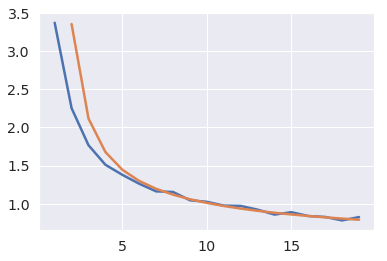

In [74]:
plt.plot(ms, variances)
plt.plot(ms, np.sqrt(2)/np.log(ms)*np.pi**2 / 6)